In [2]:
import jaxopt 

In [47]:
from pfjax.particle_resamplers import resample_mvn

In [3]:
import jax
import jax.numpy as jnp
import jax.scipy as jsp
import jax.random as random
from jax import lax
from jax.nn import softmax

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import pfjax as pf
from pfjax import particle_resamplers as resampler
import pfjax.sde as sde
import pfjax.mcmc as mcmc

In [4]:
key = random.PRNGKey(0)

In [66]:
p = 0.8
N = 20000
tau = 0.2
logp = jnp.tile(jnp.log(jnp.array([p,1-p])), (N,1)).T


In [67]:
X = random.logistic(key, (N,))
Y = 1/(1+jnp.exp((X+jnp.log(((1-p)/p)))/tau))

In [87]:
V = random.normal(random.PRNGKey(1), (N,)) -1

In [88]:
jnp.mean(Y)

DeviceArray(0.79352444, dtype=float32)

In [89]:
def smooth_bern(key, N, p, tau):
    X = random.logistic(key, (N,))
    Y = 1/(1+jnp.exp((X+jnp.log(((1-p)/p)))/tau))
    return Y

In [90]:
Y = smooth_bern(key, N, p, tau)

In [91]:
def smooth_bern_pdf(x, p, tau):
    u = x**tau * (1-p) / (p*(1-x)**tau)
    return u * tau / (1+u)**2 / ((1-x)*x)

In [92]:
def log_smooth_bern_pdf(x, p, tau):
    A = tau*jnp.log(x) + jnp.log(1-p) - jnp.log(p) - tau*jnp.log(1-x)
    B = jnp.log((p*(1-x)**tau + x**tau * (1-p))) - jnp.log(p) - tau*jnp.log(1-x)
    return A + jnp.log(tau) - 2*B - jnp.log((1-x)*x)

In [93]:
jnp.log(smooth_bern_pdf(0.1, p, tau))

DeviceArray(-1.3259647, dtype=float32, weak_type=True)

In [94]:
log_smooth_bern_pdf(0.1, p, tau)

DeviceArray(-1.3259645, dtype=float32, weak_type=True)

In [95]:
xseq = jnp.linspace(0,1,num=1000,endpoint=False)[1:]


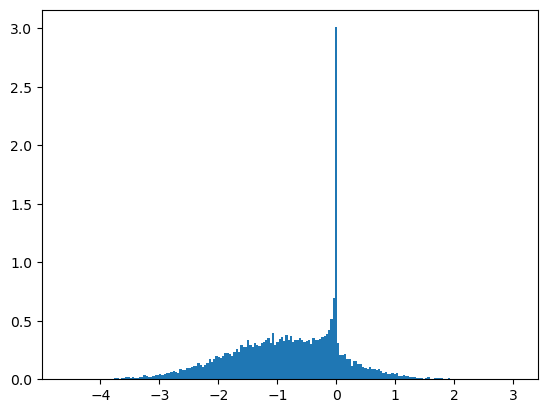

In [96]:
plt.hist(V*Y, bins=200, density=True)
#plt.plot(xseq, smooth_bern_pdf(xseq, p, tau))
plt.show()

In [14]:
def logit(p):
    return jnp.log(p/(1-p))

In [98]:
Y

DeviceArray([0.04735308, 0.18974827, 0.9911896 , ..., 0.9943347 ,
             0.9999969 , 0.83507925], dtype=float32)

In [106]:
(jnp.min(Y-1e-6))

DeviceArray(-1.e-06, dtype=float32)

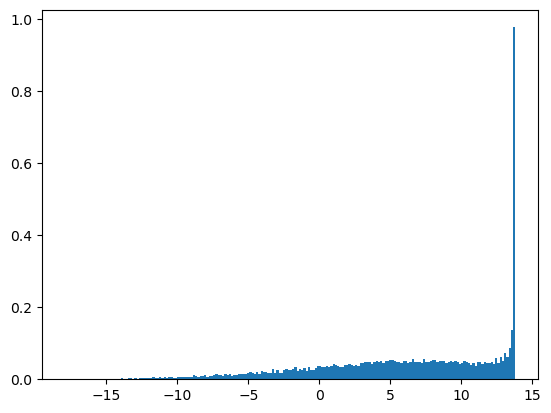

In [105]:
plt.hist(logit(Y-1e-6), bins=200, density=True)
plt.show()

In [3]:
class SDEModel(object):
    """
    Generic SDE model. 
    """
    def __init__(self, dt, n_res):
        self._dt = dt
        self._n_res = n_res
        
        def euler_sim_jump(key, x, dt, drift_diff, jump, theta):
            """
            Simulate Jump-Diffusion SDE under Euler-Maruyama scheme.
            Args:
                key: PRNG key.
                x: Current latent state, a vector of size `n_dims`.
                dt: Time between observations, a scalar. 
                drift_diff: Drift and diffusion function that returns a vector of size `n_dims`.
                jump: Jump function that returns a vector of size `n_dims`.
                theta: Static parameters, a vector of size `n_pars`.
            Returns:
                Next latent state sample. A vector of size `n_dims`.
            """
            _, diff_subkey, jump_subkey = random.split(key, 3)
            diff_process = drift_diff(diff_subkey, x, theta, dt)
            jump_process = jump(jump_subkey, x, theta, dt)
            return jnp.append(diff_process + jump_process[0:2], jump_process)
        
        def euler_sim(self, key, x, dt, theta):
            return euler_sim_jump(key, x, dt, self.drift_diff, self.jump, theta)
        
        setattr(self.__class__, 'euler_sim', euler_sim)
    
    def state_sample(self, key, x_prev, theta):
        """
        Samples from `x_curr ~ p(x_curr | x_prev, theta)`.
        Args:
            key: PRNG key.
            x_prev: Latent state at previous time, an array of size `n_res` by `n_dim`.
            theta: Static parameters, a vector of size `n_pars`.
        Returns:
            Sample of the latent state at current time, a dictionary: 
                - "x": an array of size `n_res` by `n_dim`.
                - "key": PRNG key.
        """
        def fun(carry, t):
            key, subkey = random.split(carry["key"])
            x = self.euler_sim(
                key=subkey, x=carry["x"],
                dt=self._dt/self._n_res, theta=theta
            )
            res = {"x": x, "key": key}
            return res, x
        init = {"x": x_prev[-1], "key": key}
        last, full = lax.scan(fun, init, jnp.arange(self._n_res))
        return full
    
    def is_valid(self, x, theta):
        """
        Validity check for parameter. These are turned off
        """
        return True
    
    def is_valid_state(self, x, theta):
        """
        Validity check for latent state.
        """
        return True

In [17]:
class JumpDiff_Reparam(SDEModel):
    """
    Jump-Diffusion model. 
    """
    def __init__(self, dt, n_res, bootstrap=False):
        # Inherits from the SDEModel
        super().__init__(dt, n_res) 
        self._n_state = (self._n_res, 4)
        self._tau = 0.5
        
    def drift(self, x, theta):
        """
        Drift term.
        Args:
            x: Current latent state, a vector of size `n_dims`.
            theta: Static parameters, a vector of size `n_pars`.
        Returns:
            A drift term, a vector of size 2.
        """
        theta_use = self.get_theta(theta)
        mu = jnp.array([theta_use[1]+theta_use[2]*x[0], theta_use[0]])
        return mu
    
    def diff(self, x, theta):
        """
        Diffusion term.
        Args:
            x: Current latent state, a vector of size `n_dims`.
            theta: Static parameters, a vector of size `n_pars`.
        Returns:
            A diffusion term, an array of size 2 by 2.
        """
        theta_use = self.get_theta(theta)
        Sigma = jnp.array([[x[0]*(theta_use[3]**2),0],[0,x[0]]])
        return Sigma
    
    def drift_diff(self, key, x, theta, dt):
        """
        Combines the drift, diffusion and dt terms for the diffusion process.
        Args:
            key: PRNG key.
            x: Current latent state, a vector of size `n_dims`.
            theta: Static parameters, a vector of size `n_pars`.
            dt: Time step, a scalar.
        Returns:
            The diffusion process, a vector of size 2.
        """
        theta_use = self.get_theta(theta)
        mu = jnp.array([theta_use[1]+theta_use[2]*x[0], theta_use[0]])
        Sigma = jnp.array([[x[0]*(theta_use[3]**2),0],[0,x[0]]])
        diff_process = jax.random.multivariate_normal(key, mean= x[:2] + mu*dt, cov=Sigma*dt)
        return diff_process
    
    def jump(self, key, x, theta, dt):
        """
        Jump process.
        Args:
            key: PRNG key.
            x: Current latent state, a vector of size `n_dims`.
            theta: Static parameters, a vector of size `n_pars`.
            dt: Time step, a scalar.
        Returns:
            The jump process, a vector of size 2.
        """
        theta_use = self.get_theta(theta)
        p = theta_use[4]*dt
        keys = random.split(key, 3)
        X = random.logistic(keys[0])
        is_jump = softmax(jnp.array([0.,(X+jnp.log((1-p)/p))/self._tau]))[0]
        jump_process = is_jump * jnp.array([theta_use[7]*jax.random.exponential(keys[1]), 
                                            theta_use[5] + theta_use[6]*jax.random.normal(keys[2])])
        return jump_process
    
    def get_theta(self, theta):
        """
        Retrieves the static parameters to the regular scale.
        Args:
            theta: Static parameters, a vector of size `n_pars`.
        Returns:
            The static parameters in the regular scale.
        """
        return jnp.array([theta[0], theta[1], theta[2], 
                          jnp.exp(theta[3]), 
                          jnp.exp(theta[4]), 
                          theta[5], 
                          jnp.exp(theta[6]), 
                          jnp.exp(theta[7])])
    
    def meas_lpdf(self, y_curr, x_curr, theta):
        """
        The log-density the error-free measurement model.
        Args:
            y_curr: Observation at current time, a scalar.
            x_curr: Current latent state, an array of size `n_res` by `n_dim`.
            theta: Static parameters, a vector of size `n_pars`.
        Returns:
            0.0, since measurement model is a delta function.
        """
        return 0.0
    
    def meas_sample(self, key, x_curr, theta):
        """
        Sample from the error-free measurement model.
        Args:
            key: PRNG key.
            x_curr: Current latent state, an array of size `n_res` by `n_dim`.
            theta: Static parameters, a vector of size `n_pars`.
        Returns:
            Sample of the observation at current time, a scalar.
        """
        return x_curr[-1][1]
    
    def state_lpdf_lean(self, x_curr, x_prev, theta):
        """
        The log-density of transition of the latent states.
        Args:
            x_curr: Current latent state, an array of size `n_res` by `n_dim`.
            x_prev: Latent state at previous time, an array of size `n_res` by `n_dim`.
            theta: Static parameters, a vector of size `n_pars`.
        Returns:
            Log-density, a scalar.
        """
        x0 = jnp.concatenate([x_prev[-1][None], x_curr[:-1]])
        x1 = x_curr
        
        def euler_lpdf_jump(x_curr, x_prev, dt, drift, diff, theta):
            return jsp.stats.norm.logpdf(
                x=x_curr[1],
                loc=x_prev[1] + drift(x_prev, theta)[1]*dt + x_curr[3],
                scale=jnp.sqrt(diff(x_prev, theta)[1,1]*dt)
            ) 
        
        lp = jax.vmap(lambda xp, xc:
                      euler_lpdf_jump(
                          x_curr=xc, x_prev=xp,
                          dt=self._dt/self._n_res,
                          drift=self.drift,
                          diff=self.diff,
                          theta=theta))(x0, x1)
        return jnp.sum(lp)
    
    def state_lpdf(self, x_curr, x_prev, theta):
        """
        The log-density of transition of the latent states.
        Args:
            x_curr: Current latent state, an array of size `n_res` by `n_dim`.
            x_prev: Latent state at previous time, an array of size `n_res` by `n_dim`.
            theta: Static parameters, a vector of size `n_pars`.
        Returns:
            Log-density, a scalar.
        """
        x0 = jnp.concatenate([x_prev[-1][None], x_curr[:-1]])
        x1 = x_curr
        
        def euler_lpdf_jump(x_curr, x_prev, dt, drift, diff, theta):
            theta_use = self.get_theta(theta)
            
            diff_lpdf = jsp.stats.multivariate_normal.logpdf(
                x=x_curr[0:2],
                mean=x_prev[0:2] + drift(x_prev, theta)*dt + x_curr[2:4],
                cov=diff(x_prev, theta)*dt
            )
            
            jump_lpdf = log_smooth_bern_pdf(x_curr[4], theta_use[4]*dt, self._tau) \
                                 - jnp.log(theta_use[7]) - x_curr[2]/theta_use[7] \
                                 + jsp.stats.norm.logpdf(x_curr[3], theta_use[5], theta_use[6])
            return diff_lpdf + jump_lpdf
        
        lp = jax.vmap(lambda xp, xc:
                      euler_lpdf_jump(
                          x_curr=xc, x_prev=xp,
                          dt=self._dt/self._n_res,
                          drift=self.drift,
                          diff=self.diff,
                          theta=theta))(x0, x1)
        return jnp.sum(lp)
    
    def _bridge_param(self, x, y_curr, theta, n, vz, vx, vx_invcumsum):
        """
        Calculate the mean and variance of the bridge proposal.
        Args:
            x: Current latent state, a vector of size `n_dims`.
            y_curr: Observation at current time, a scalar.
            theta: Static parameters, a vector of size `n_pars`.
            n: Index of the subinterval, a scalar.
            vz: Jump size in log asset price, a scalar.
            vx: Jump size in volatility, a scalar.
            vx_invcumsum: n-th inverse cumulative sum of volatility jump sizes, a scalar.
        Returns:
            Bridge mean and variance of the bridge proposal, a tuple of scalars.
        """
        k = self._n_res - n
        dt_res = self._dt/self._n_res
        theta_use = self.get_theta(theta)

        mu_z = x[0] + (theta_use[1]+theta_use[2]*x[0])*dt_res + vz
        sig2_z = x[0]*(theta_use[3]**2)*dt_res

        mu_x = x[1] + (y_curr - x[1])/k + vx - vx_invcumsum/k
        sig2_x = (k - 1)/k*x[0]*dt_res

        return mu_z, sig2_z, mu_x, sig2_x
    
    def pf_step(self, key, x_prev, y_curr, theta):
        """
        Particle update for a bridge particle filter.
        Args:
            key: PRNG key.
            x_prev: State variable at previous time `t-1`.
            y_curr: Measurement variable at current time `t`.
            theta: Parameter value.
        Returns:
            The result of the particle update, a tuple:
                - x_curr: Current latent state sample, an array of size `n_res` by `n_dim`.
                - logw: The log-weight of the particle, a scalar.
        """
        key, jump_subkey, z_subkey, x_subkey = random.split(key, 4)
        dt_res = self._dt/self._n_res
        
        def scan_fun(carry, t):
            key = carry["key"]
            x = carry["x"]

            n, vz, vx, vx_invcumsum, jump = t
            mu_z, sig2_z, mu_x, sig2_x = self._bridge_param(x, y_curr, theta, n, vz, vx, vx_invcumsum)

            key, z_subkey, x_subkey = random.split(key,3)

            x_prop = jnp.array([jnp.abs(mu_z + jnp.sqrt(sig2_z) * random.normal(z_subkey))+1e-10,
                                jnp.where(n<self._n_res-1, 
                                          mu_x + jnp.sqrt(sig2_x) * random.normal(x_subkey),
                                          y_curr),
                                vz, vx])

            lp_prop = jnp.where(n<self._n_res-1,
                                jsp.stats.norm.logpdf(x=x_prop[1], loc=mu_x, scale=jnp.sqrt(sig2_x)),
                                0.0)

            res_carry = {
                "x": x_prop,
                "key": key,
                "lp": carry["lp"] + lp_prop
            }

            res_stack = {"x": x_prop, "lp": lp_prop}

            return res_carry, res_stack

        scan_init = {
            "x": x_prev[self._n_res-1],
            "key": key,
            "lp": jnp.array(0.)
        }
        
        theta_use = self.get_theta(theta)
        p = theta_use[4]*dt_res
        
        ns = jnp.arange(self._n_res)
        Xs = random.logistic(jump_subkey, shape=(self._n_res,))
        jumps = 1/(1+jnp.exp((Xs+jnp.log((1-p)/p))/self._tau))
        vzs = theta_use[7]*jax.random.exponential(z_subkey, shape=(self._n_res,))*jumps
        vxs = (theta_use[5]+theta_use[6]*jax.random.normal(x_subkey, shape=(self._n_res,)))*jumps
        vxs_invcumsum = jax.lax.cumsum(vxs[::-1])[::-1]

        last, full = lax.scan(scan_fun, scan_init, (ns,vzs,vxs,vxs_invcumsum,jumps))

        x_prop = full["x"]

        logw_trans = self.state_lpdf_lean(
            x_curr=x_prop,
            x_prev=x_prev, 
            theta=theta
        )

        logw = logw_trans - last["lp"]

        return x_prop, logw
    
    def pf_init(self, key, y_init, theta):
        """
        Initializer for the particle filter.
        Args:
            key: PRNG key.
            y_init: Initial observation, a scalar.
            theta: Static parameters, a vector of size `n_pars`.
        Returns:
            The result of the particle initialization, a tuple:
                - x_curr: Current latent state sample, an array of size `n_res` by `n_dim`.
                - logw: The log-weight of the particle, a scalar.
        """
        key, subkey = random.split(key)
        x_init = y_init + 5*random.normal(
            subkey
        )
        z_init = random.truncated_normal(
            subkey,
            lower=0.5,
            upper=10)
        logw = jnp.sum(jsp.stats.norm.logcdf(y_init))
        return \
            jnp.append(jnp.zeros((self._n_res-1,) + (self._n_state[1], )),
                       jnp.expand_dims(jnp.array([z_init, x_init, 0.0, 0.0]), axis = 0), axis=0), \
            logw


In [5]:
class JumpDiff(SDEModel):
    """
    Jump-Diffusion model. 
    """
    def __init__(self, dt, n_res, bootstrap=False):
        # Inherits from the SDEModel
        super().__init__(dt, n_res) 
        self._n_state = (self._n_res, 5)
        
    def drift(self, x, theta):
        """
        Drift term.
        Args:
            x: Current latent state, a vector of size `n_dims`.
            theta: Static parameters, a vector of size `n_pars`.
        Returns:
            A drift term, a vector of size 2.
        """
        theta_use = self.get_theta(theta)
        mu = jnp.array([theta_use[1]+theta_use[2]*x[0], theta_use[0]])
        return mu
    
    def diff(self, x, theta):
        """
        Diffusion term.
        Args:
            x: Current latent state, a vector of size `n_dims`.
            theta: Static parameters, a vector of size `n_pars`.
        Returns:
            A diffusion term, an array of size 2 by 2.
        """
        theta_use = self.get_theta(theta)
        Sigma = jnp.array([[x[0]*(theta_use[3]**2),0],[0,x[0]]])
        return Sigma
    
    def drift_diff(self, key, x, theta, dt):
        """
        Combines the drift, diffusion and dt terms for the diffusion process.
        Args:
            key: PRNG key.
            x: Current latent state, a vector of size `n_dims`.
            theta: Static parameters, a vector of size `n_pars`.
            dt: Time step, a scalar.
        Returns:
            The diffusion process, a vector of size 2.
        """
        theta_use = self.get_theta(theta)
        mu = jnp.array([theta_use[1]+theta_use[2]*x[0], theta_use[0]])
        Sigma = jnp.array([[x[0]*(theta_use[3]**2),0],[0,x[0]]])
        diff_process = jax.random.multivariate_normal(key, mean= x[:2] + mu*dt, cov=Sigma*dt)
        return diff_process
    
    def jump(self, key, x, theta, dt):
        """
        Jump process.
        Args:
            key: PRNG key.
            x: Current latent state, a vector of size `n_dims`.
            theta: Static parameters, a vector of size `n_pars`.
            dt: Time step, a scalar.
        Returns:
            The jump process, a vector of size 2.
        """
        theta_use = self.get_theta(theta)
        keys = random.split(key, 3)
        is_jump = jax.random.bernoulli(keys[0], p=theta_use[4]*dt)
        jump_process = jnp.where(is_jump==1.0, 
                                 jnp.array([theta_use[7]*jax.random.exponential(keys[1]), 
                                            theta_use[5] + theta_use[6]*jax.random.normal(keys[2]),
                                            is_jump]),
                                 jnp.array([0.0,0.0,0.0]))
        return jump_process
    
    def get_theta(self, theta, eps=0):
        """
        Retrieves the static parameters to the regular scale.
        Args:
            theta: Static parameters, a vector of size `n_pars`.
        Returns:
            The static parameters in the regular scale.
        """
        return jnp.array([theta[0], theta[1], theta[2], 
                          jnp.exp(theta[3]), 
                          jnp.exp(theta[4])+eps, 
                          theta[5], 
                          jnp.exp(theta[6]), 
                          jnp.exp(theta[7])])
    
    def meas_lpdf(self, y_curr, x_curr, theta):
        """
        The log-density the error-free measurement model.
        Args:
            y_curr: Observation at current time, a scalar.
            x_curr: Current latent state, an array of size `n_res` by `n_dim`.
            theta: Static parameters, a vector of size `n_pars`.
        Returns:
            0.0, since measurement model is a delta function.
        """
        return 0.0
    
    def meas_sample(self, key, x_curr, theta):
        """
        Sample from the error-free measurement model.
        Args:
            key: PRNG key.
            x_curr: Current latent state, an array of size `n_res` by `n_dim`.
            theta: Static parameters, a vector of size `n_pars`.
        Returns:
            Sample of the observation at current time, a scalar.
        """
        return x_curr[-1][1]
    
    def state_lpdf_lean(self, x_curr, x_prev, theta):
        """
        The log-density of transition of the latent states.
        Args:
            x_curr: Current latent state, an array of size `n_res` by `n_dim`.
            x_prev: Latent state at previous time, an array of size `n_res` by `n_dim`.
            theta: Static parameters, a vector of size `n_pars`.
        Returns:
            Log-density, a scalar.
        """
        x0 = jnp.concatenate([x_prev[-1][None], x_curr[:-1]])
        x1 = x_curr
        
        def euler_lpdf_jump(x_curr, x_prev, dt, drift, diff, theta):
            return jsp.stats.norm.logpdf(
                x=x_curr[1],
                loc=x_prev[1] + drift(x_prev, theta)[1]*dt + x_curr[3],
                scale=jnp.sqrt(diff(x_prev, theta)[1,1]*dt)
            ) 
        
        lp = jax.vmap(lambda xp, xc:
                      euler_lpdf_jump(
                          x_curr=xc, x_prev=xp,
                          dt=self._dt/self._n_res,
                          drift=self.drift,
                          diff=self.diff,
                          theta=theta))(x0, x1)
        return jnp.sum(lp)
    
    def state_lpdf(self, x_curr, x_prev, theta):
        """
        The log-density of transition of the latent states.
        Args:
            x_curr: Current latent state, an array of size `n_res` by `n_dim`.
            x_prev: Latent state at previous time, an array of size `n_res` by `n_dim`.
            theta: Static parameters, a vector of size `n_pars`.
        Returns:
            Log-density, a scalar.
        """
        x0 = jnp.concatenate([x_prev[-1][None], x_curr[:-1]])
        x1 = x_curr
        
        def euler_lpdf_jump(x_curr, x_prev, dt, drift, diff, theta):
            theta_use = self.get_theta(theta)
            
            diff_lpdf = jsp.stats.multivariate_normal.logpdf(
                x=x_curr[0:2],
                mean=x_prev[0:2] + drift(x_prev, theta)*dt + x_curr[2:4],
                cov=diff(x_prev, theta)*dt
            )
            
            jump_lpdf = lax.cond(x_curr[4]==1,
                                 lambda: jnp.log(theta_use[4]*dt) - jnp.log(theta_use[7]) - x_curr[2]/theta_use[7] + jsp.stats.norm.logpdf(x_curr[3], theta_use[5], theta_use[6]),
                                 lambda: jnp.log(1-theta_use[4]*dt)) 
        
            return diff_lpdf + jump_lpdf
        
        lp = jax.vmap(lambda xp, xc:
                      euler_lpdf_jump(
                          x_curr=xc, x_prev=xp,
                          dt=self._dt/self._n_res,
                          drift=self.drift,
                          diff=self.diff,
                          theta=theta))(x0, x1)
        return jnp.sum(lp)
    
    def _state_lpdf_for(self, x_curr, x_prev, theta):
        """
        For-loop version of the `state_lpdf`.
        """
        dt_res = self._dt/self._n_res
        x0 = jnp.append(jnp.expand_dims(
            x_prev[self._n_res-1], axis=0), x_curr[:self._n_res-1], axis=0)
        x1 = x_curr
        lp = jnp.array(0.0)
        
        for t in range(self._n_res):
            lp = lp + jnp.sum(jsp.stats.norm.logpdf(
                x=x1[t][1],
                loc=x0[t][1] + self.drift(x0[t], theta)[1]*dt_res + x1[t][3],
                scale=jnp.sqrt(self.diff(x0[t], theta)[1,1]*dt_res)
            ))
        return lp
    
    def _bridge_param(self, x, y_curr, theta, n, vz, vx, vx_invcumsum):
        """
        Calculate the mean and variance of the bridge proposal.
        Args:
            x: Current latent state, a vector of size `n_dims`.
            y_curr: Observation at current time, a scalar.
            theta: Static parameters, a vector of size `n_pars`.
            n: Index of the subinterval, a scalar.
            vz: Jump size in log asset price, a scalar.
            vx: Jump size in volatility, a scalar.
            vx_invcumsum: n-th inverse cumulative sum of volatility jump sizes, a scalar.
        Returns:
            Bridge mean and variance of the bridge proposal, a tuple of scalars.
        """
        k = self._n_res - n
        dt_res = self._dt/self._n_res
        theta_use = self.get_theta(theta)

        mu_z = x[0] + (theta_use[1]+theta_use[2]*x[0])*dt_res + vz
        sig2_z = x[0]*(theta_use[3]**2)*dt_res

        mu_x = x[1] + (y_curr - x[1])/k + vx - vx_invcumsum/k
        sig2_x = (k - 1)/k*x[0]*dt_res

        return mu_z, sig2_z, mu_x, sig2_x
    
    def pf_step(self, key, x_prev, y_curr, theta):
        """
        Particle update for a bridge particle filter.
        Args:
            key: PRNG key.
            x_prev: State variable at previous time `t-1`.
            y_curr: Measurement variable at current time `t`.
            theta: Parameter value.
        Returns:
            The result of the particle update, a tuple:
                - x_curr: Current latent state sample, an array of size `n_res` by `n_dim`.
                - logw: The log-weight of the particle, a scalar.
        """
        key, jump_subkey, z_subkey, x_subkey = random.split(key, 4)

        def scan_fun(carry, t):
            key = carry["key"]
            x = carry["x"]

            n, vz, vx, vx_invcumsum, jump = t
            mu_z, sig2_z, mu_x, sig2_x = self._bridge_param(x, y_curr, theta, n, vz, vx, vx_invcumsum)

            key, z_subkey, x_subkey = random.split(key,3)

            x_prop = jnp.array([jnp.abs(mu_z + jnp.sqrt(sig2_z) * random.normal(z_subkey))+1e-10,
                                jnp.where(n<self._n_res-1, 
                                          mu_x + jnp.sqrt(sig2_x) * random.normal(x_subkey),
                                          y_curr),
                                vz, vx, jump])

            lp_prop = jnp.where(n<self._n_res-1,
                                jsp.stats.norm.logpdf(x=x_prop[1], loc=mu_x, scale=jnp.sqrt(sig2_x)),
                                0.0)

            res_carry = {
                "x": x_prop,
                "key": key,
                "lp": carry["lp"] + lp_prop
            }

            res_stack = {"x": x_prop, "lp": lp_prop}

            return res_carry, res_stack

        scan_init = {
            "x": x_prev[self._n_res-1],
            "key": key,
            "lp": jnp.array(0.)
        }
        
        theta_use = self.get_theta(theta)
        
        ns = jnp.arange(self._n_res)
        jumps = jax.random.bernoulli(jump_subkey, shape=(self._n_res,), p=theta_use[4]*self._dt/self._n_res)
        vzs = theta_use[7]*jax.random.exponential(z_subkey, shape=(self._n_res,))*jumps
        vxs = (theta_use[5]+theta_use[6]*jax.random.normal(x_subkey, shape=(self._n_res,)))*jumps
        vxs_invcumsum = jax.lax.cumsum(vxs[::-1])[::-1]

        last, full = lax.scan(scan_fun, scan_init, (ns,vzs,vxs,vxs_invcumsum,jumps))

        x_prop = full["x"]

        logw_trans = self.state_lpdf_lean(
            x_curr=x_prop,
            x_prev=x_prev, 
            theta=theta
        )

        logw = logw_trans - last["lp"]

        return x_prop, logw
    
    def _pf_step_for(self, key, x_prev, y_curr, theta):
        """
        For-loop version of the `pf_step()`.
        """
        dt_res = self._dt/self._n_res
        x_curr = []
        x_state = x_prev[self._n_res-1]
        lp = jnp.array(0.0)
        theta_use = self.get_theta(theta)
        
        key, jump_subkey, z_subkey, x_subkey = random.split(key, 4)
        
        jumps = jax.random.bernoulli(jump_subkey, shape=(self._n_res,), p=theta_use[4]*self._dt/self._n_res)
        vzs = theta_use[7]*jax.random.exponential(z_subkey, shape=(self._n_res,))*jumps
        vxs = (theta_use[5]+theta_use[6]*jax.random.normal(x_subkey, shape=(self._n_res,)))*jumps
        vxs_invcumsum = jax.lax.cumsum(vxs[::-1])[::-1]
        
        for t in range(self._n_res):
            key, z_subkey, x_subkey = random.split(key,3)
            mu_z, sig2_z, mu_x, sig2_x = self._bridge_param(x_state, y_curr, theta, t, 
                                                            vzs[t], vxs[t], vxs_invcumsum[t])
            
            x_state = jnp.array([jnp.abs(mu_z + jnp.sqrt(sig2_z) * random.normal(z_subkey))+1e-10,
                                 jnp.where(t<self._n_res-1, 
                                           mu_x + jnp.sqrt(sig2_x) * random.normal(x_subkey),
                                           y_curr),
                                 vzs[t], vxs[t]])

            lp_prop = jnp.where(t<self._n_res-1,
                           jsp.stats.norm.logpdf(x=x_state[1], loc=mu_x, scale=jnp.sqrt(sig2_x)),
                           0.0)
            
            x_curr.append(x_state)
            lp = lp + lp_prop
        
        x_prop = jnp.array(x_curr)
        
        logw_trans = self._state_lpdf_for(
            x_curr=x_prop,
            x_prev=x_prev, 
            theta=theta
        )
        
        logw = logw_trans - lp
        
        return x_prop, logw
    
    def pf_init(self, key, y_init, theta):
        """
        Initializer for the particle filter.
        Args:
            key: PRNG key.
            y_init: Initial observation, a scalar.
            theta: Static parameters, a vector of size `n_pars`.
        Returns:
            The result of the particle initialization, a tuple:
                - x_curr: Current latent state sample, an array of size `n_res` by `n_dim`.
                - logw: The log-weight of the particle, a scalar.
        """
        key, subkey = random.split(key)
        x_init = y_init + 5*random.normal(
            subkey
        )
        z_init = random.truncated_normal(
            subkey,
            lower=0.5,
            upper=10)
        logw = jnp.sum(jsp.stats.norm.logcdf(y_init))
        return \
            jnp.append(jnp.zeros((self._n_res-1,) + (self._n_state[1], )),
                       jnp.expand_dims(jnp.array([z_init, x_init, 0.0, 0.0, 0.0]), axis = 0), axis=0), \
            logw


In [18]:
my_key = random.PRNGKey(0)

my_dt = 1
my_n_res = 5
my_n_obs = 300
my_theta = jnp.array([0.08, 0.02, -0.03, jnp.log(0.12), jnp.log(0.05), -3.1, jnp.log(2.7), jnp.log(1.7)])

In [42]:
jdmodel = JumpDiff(my_dt, my_n_res)
my_x_init = jnp.block([[jnp.zeros((my_n_res-1, 5))],
                    [jnp.array([2.0, 100.0,0,0,0])]])
y_meas, x_state = pf.simulate(jdmodel, my_key, my_n_obs, my_x_init, my_theta)


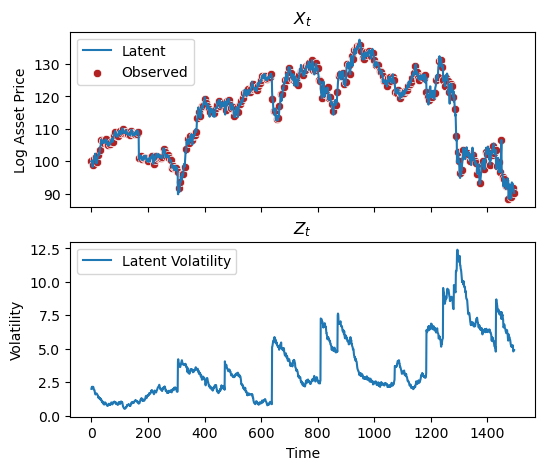

In [43]:
tmp = pd.DataFrame(jnp.array([
    jnp.arange(y_meas.shape[0]) * my_n_res,
    y_meas
]).T, columns = ["Time", "Log Asset Price"])

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(6, 5), sharey = False, sharex=True)

sns.lineplot(data= x_state[:,:,1].reshape(my_n_res*my_n_obs,1)[(my_n_res-1):].squeeze(),
             ax = ax[0],
             label = "Latent")
# plt.plot(y_meas)
sns.lineplot(data= x_state[:,:,0].reshape(my_n_res*my_n_obs,1)[(my_n_res-1):].squeeze(),
             ax = ax[1],
             label = "Latent Volatility").set(xlabel="Time",title = "$Z_t$", ylabel="Volatility");

sns.scatterplot(x = "Time", y = "Log Asset Price", 
                data = tmp,
                color = "firebrick",
                ax = ax[0],
                label="Observed").set(title ="$X_t$");


In [58]:
pf.particle_filter(
            model=jdmodel,
            key=random.PRNGKey(0),
            y_meas=y_meas,
            theta=my_theta,
            n_particles=100,
            resampler=resample_mvn,
    
        )

{'key': DeviceArray([2487415287, 3593198636], dtype=uint32),
 'loglik': DeviceArray(nan, dtype=float32),
 'logw': DeviceArray([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
              nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
              nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
              nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
              nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
              nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
              nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
              nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
              nan, nan, nan, nan], dtype=float32),
 'x_particles': DeviceArray([[[      nan,       nan,  0.      ,  0.      ,  0.      ],
               [      nan,       nan,  0.      ,  0.      ,  0.      ],
               [      nan,       nan,  0.      ,  0.      ,  0.      ],
             

In [19]:
jdmodel_reparam = JumpDiff_Reparam(my_dt, my_n_res)
my_x_init = jnp.block([[jnp.zeros((my_n_res-1, 4))],
                    [jnp.array([2.0, 100.0,0,0])]])
y_meas, x_state = pf.simulate(jdmodel_reparam, my_key, my_n_obs, my_x_init, my_theta)


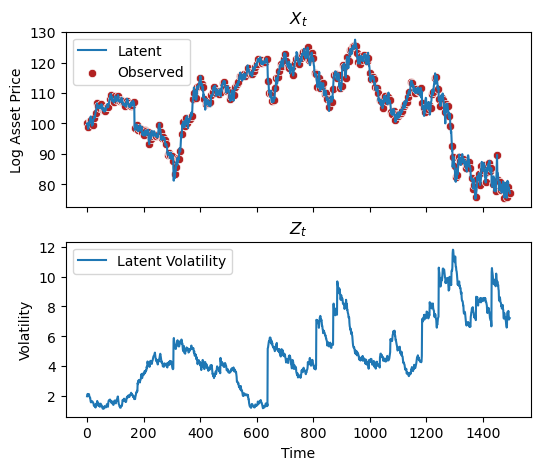

In [20]:
tmp = pd.DataFrame(jnp.array([
    jnp.arange(y_meas.shape[0]) * my_n_res,
    y_meas
]).T, columns = ["Time", "Log Asset Price"])

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(6, 5), sharey = False, sharex=True)

sns.lineplot(data= x_state[:,:,1].reshape(my_n_res*my_n_obs,1)[(my_n_res-1):].squeeze(),
             ax = ax[0],
             label = "Latent")
# plt.plot(y_meas)
sns.lineplot(data= x_state[:,:,0].reshape(my_n_res*my_n_obs,1)[(my_n_res-1):].squeeze(),
             ax = ax[1],
             label = "Latent Volatility").set(xlabel="Time",title = "$Z_t$", ylabel="Volatility");

sns.scatterplot(x = "Time", y = "Log Asset Price", 
                data = tmp,
                color = "firebrick",
                ax = ax[0],
                label="Observed").set(title ="$X_t$");


In [49]:
def particle_gibbs(key, model, n_iter, theta_init, x_state_init, n_particles, rw_sd):
    """
    Sample from the joint posterior distribution of parameters and latent states using a Particle Gibbs sampler.

    Args:
        key: PRNG key.
        n_iter: Number of MCMC iterations.
        theta_init: A vector of `n_params` initial parameter values on the unconstrained scale.
        x_state_init: JAX PyTree of initial state variables.
        n_particles: Number of particles for the particle filter.
        rw_sd: Vector of `n_params` initial standard deviations for the adaptive MWG proposal.

    Returns:
        A dictionary with elements

        - **x_state** - MCMC output for the state variables, with leading dimension `n_iter`.
        - **theta** - MCMC output for the unconstrained parameters, with leading dimension `n_iter`.
        - **accept_rate** - Vector of `n_params` acceptance rates.  These should be close to 0.44.
    """
    # initialize the sampler
    n_params = theta_init.size
    amwg = mcmc.AdaptiveMWG(adapt_max=0.1, adapt_rate=0.01)
    # initial state of MWG sampler
    initial_state = {
        "theta": theta_init,
        "x_state": x_state_init,
        "adapt_pars": amwg.init(rw_sd),
    }

    def mcmc_update(key, theta, x_state, adapt_pars):
        """
        MCMC update for parameters and latent variables.

        Use Adaptive MWG for the former and a particle filter for the latter.
        """
        keys = jax.random.split(key, num=3) # two for particle_filter, one for amwg
        # latent variable update
        pf_out = a
        x_state = pf.particle_smooth(
            key=keys[1],
            logw=pf_out["logw"][y_meas.shape[0]-1],
            x_particles=pf_out["x_particles"],
            ancestors=pf_out["resample_out"]["ancestors"]
        )
        # parameter update
        def logpost(theta):
            """
            Log-posterior of the conditional parameter distribution.
            """
            return pf.loglik_full(
                model=model,
                theta=theta,
                x_state=x_state,
                y_meas=y_meas
            )
        theta_state, accept = amwg.step(
            key=keys[2],
            position=theta,
            logprob_fn=logpost,
            rw_sd=adapt_pars["rw_sd"]
        )
        # adapt random walk jump sizes
        adapt_pars = amwg.adapt(pars=adapt_pars, accept=accept)
        return theta_state, x_state, adapt_pars, accept

    @jax.jit
    def step(state, key):
        """
        One step of MCMC update.
        """
        theta, x_state, adapt_pars, accept = mcmc_update(
            key=key,
            theta=state["theta"],
            x_state=state["x_state"],
            adapt_pars=state["adapt_pars"]
        )
        new_state = {
            "theta": theta, 
            "x_state": x_state, 
            "adapt_pars": adapt_pars
        }
        stack_state = {
            "theta": theta, 
            "x_state": x_state
        }
        return new_state, stack_state
    
    keys = jax.random.split(key, num=n_iter)
    state, out = jax.lax.scan(step, initial_state, keys)
    # calculate acceptance rate
    out["accept_rate"] = (1.0 * state["adapt_pars"]["n_accept"]) / n_iter
    return out

In [50]:
n_particles = 100
rw_sd = 0.0001*jnp.ones(len(my_theta))
n_iter = 1000

key, subkey = jax.random.split(my_key)

import time
t = time.process_time()
pg_out = particle_gibbs(
    key=subkey, 
    model=jdmodel,
    n_iter=n_iter, 
    theta_init=my_theta, 
    x_state_init=x_state, 
    n_particles=n_particles, 
    rw_sd=rw_sd
)
elapsed_time = time.process_time() - t

pg_out["accept_rate"] # should be close to 0.44

DeviceArray([0.464, 0.415, 0.437, 0.433, 0.403, 0.465, 0.461, 0.411], dtype=float32)

In [51]:
elapsed_time

50.85187499999995

In [52]:
my_theta

DeviceArray([ 0.08      ,  0.02      , -0.03      , -2.1202636 ,
             -2.9957323 , -3.1       ,  0.9932518 ,  0.53062826],            dtype=float32)

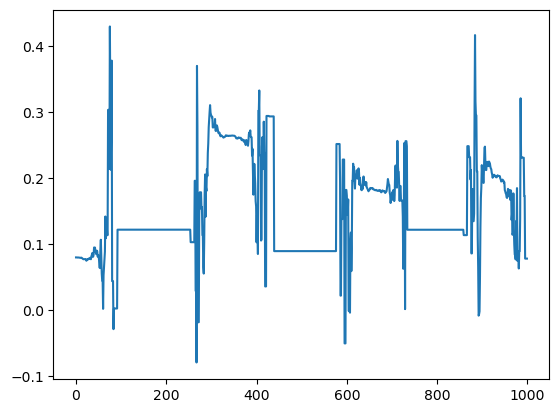

In [53]:
plt.plot(pg_out['theta'][:,0])

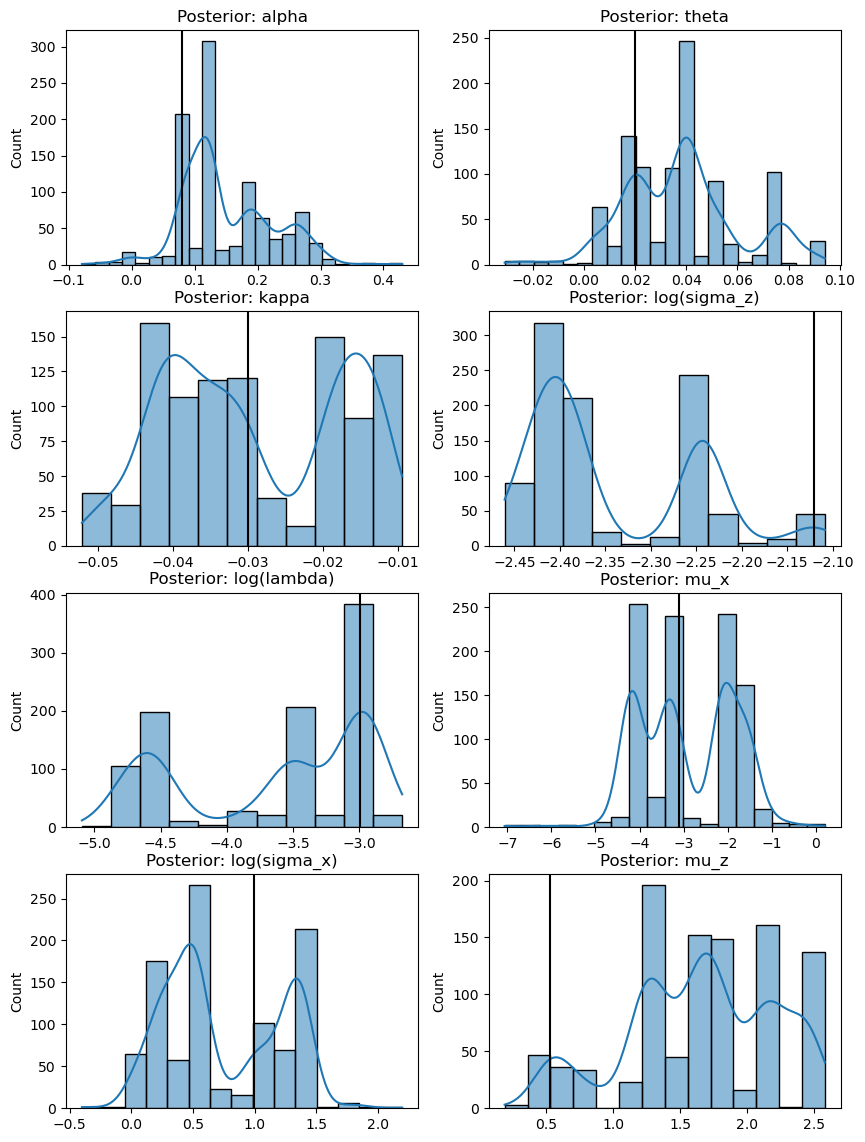

In [39]:
pg_theta = pg_out['theta'] #jax.vmap(jdmodel.get_theta, in_axes=(0,))(pg_out['theta'])
plot_pg = pd.DataFrame({"iter": jnp.arange(n_iter),
                         "alpha": pg_theta[:,0],
                         "theta": pg_theta[:,1],
                         "kappa": pg_theta[:,2],
                         "log(sigma_z)": pg_theta[:,3],
                         "log(lambda)": pg_theta[:,4],
                         "mu_x": pg_theta[:,5],
                         "log(sigma_x)": pg_theta[:,6],
                         "mu_z": pg_theta[:,7]})

fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(10, 14), sharex=False, sharey=False)
axes = axes.ravel()  # array to 1D
cols = plot_pg.columns[1:]  # create a list of dataframe columns to use

for col, ax in zip(cols, axes):
    data=plot_pg[[col]]
    sns.histplot(data=data, x=col, kde=True, ax=ax)
    ax.set(title=f'Posterior: {col}', xlabel=None)

for ax, theta in zip(axes, my_theta):
    ax.axvline(theta, color="black")
    

In [140]:
class AdaptiveMetropolis:
    r"""
    Adaptive Metropolis in Roberts and Rosenthal (2009).

    Args:
        mix_par: Scalar of mixing parameter in the Gaussian mixture model.
        adapt_rate: Scalar of covariance inflation parameter.

    .. _BlackJAX: https://blackjax-devs.github.io/blackjax/index.html
    .. |BlackJAX| replace:: **BlackJAX**
    """

    def __init__(self, max_iter=100, mix_par=0.05, infl_par=2.38):
        self._max_iter = max_iter
        self._mix_par = mix_par
        self._infl_par = infl_par
        
    def adapt(self, pars, position_new):
        r"""
        Update empirical covariance matrix.

        Args:
            pars: Adaptation parameters.  A dictionary with elements:

                - `XTX`: Array of transpose product of parameter draws.
                - `EX`: Empirical average of parameter draws.
                - `cov_prop`: Current proposal covariance matrix.
                - `n_iter`: Number of AM iterations (cycles) so far.
                - `n_accept`:The number of accepted draws so far.
            
            position_new: New draw of parameters.
            accept: Boolean vector indicating whether or not the latest proposal was accepted.

        Returns:
            Dictionary:
            
            - **n_iter** - Updated number of iterations, i.e., ``n_iter += 1``.
            - **n_accept** - Updated number of accepted draws, i.e., ``n_accept += accept``.
        """
        n_iter = pars["n_iter"] + 1.
        
        # Updating necessary terms to compute empirical covariance
        XTX = (pars["XTX"] * (n_iter-1) + jnp.outer(position_new, position_new)) / n_iter
        EX = (pars["EX"] * (n_iter-1) + position_new) / n_iter
        
        # Empirical covariance structure of parameters
        Sigma = (XTX - jnp.outer(EX, EX))*n_iter/(n_iter-1)
        cov1 = pars["cov_pars"]["cov1"]
        cov2 = lax.cond(n_iter>self._max_iter,
                        lambda: self._infl_par**2 * Sigma, # inflated covariance
                        lambda: cov1)
        
        return {
            "cov_pars": {
                "cov1": cov1,
                "cov2": cov2,
                "mix_par": self._mix_par
            },
            "XTX": XTX,
            "EX": EX,
            "n_iter": n_iter
        }
    
    def init(self, cov1):
        r"""
        Initialize the adaptation parameters.

        Args:
            rw_sd: A vector of initial standard deviations for the componentwise random walk proposal.

        Returns: 

            Dictionary:

            - **rw_sd** - The vector of  standard deviations for the componentwise random walk proposal.
            - **n_iter** - The number of MWG steps taken so far, which is zero.
            - **n_accept** - The number of draws accepted so far, which is zero.
        """
        d = cov1.shape[0]
        return {
            "cov_pars": {
                "cov1": cov1,
                "cov2": cov1,
                "mix_par": self._mix_par
            },
            "XTX": jnp.zeros((d,d)),
            "EX": jnp.zeros(d),
            "n_iter": 0
        }

    def step(self, key, position_curr, lp_curr, logprob_fn, mix_par, cov1, cov2):
        r"""
        Update parameters via adaptive Metropolis-within-Gibbs.

        Args:
            key: PRNG key.
            position: The current position of the sampler.
            logprob_fn: Function which takes a JAX array input `position` and returns a scalar corresponding to the log of the probability density at that input.
            
        Returns: 

            Tuple:

            - **position** - The updated position.
            - **accept** - Scalar indicating whether or not proposal was accepted.
        """
        
        # 3 subkeys for each position: mixture draw, parameter draw and MH accept
        key, *subkeys = random.split(key, num=5)
        draw = random.bernoulli(subkeys[0], p=mix_par)
        d = len(position_curr)
        
        # covariance matrix        
        cov = cov1 * draw + cov2 * (1-draw)
        
        # proposal
        position_prop = random.multivariate_normal(key=subkeys[1],
                                                   mean=position_curr,
                                                   cov=cov)
        # acceptance rate
        lp_prop = logprob_fn(position_prop, subkeys[2])
        lrate = lp_prop - lp_curr
        # update parameter draw
        acc = random.bernoulli(key=subkeys[3],
                               p=jnp.minimum(1.0, jnp.exp(lrate)))
        position = position_prop * acc + position_curr * (1-acc)
        lp = lp_prop * acc + lp_curr * (1-acc)
        
        return position, acc, lp


In [105]:
def adaptive_metropolis_x_fixed(key, model, am, y_meas, n_iter, theta_init, x_state_init, n_particles, logprior, cov1):
    """
    Sample from the joint posterior distribution of parameters and latent states using a Particle Gibbs sampler.

    Args:
        key: PRNG key.
        n_iter: Number of MCMC iterations.
        theta_init: A vector of `n_params` initial parameter values on the unconstrained scale.
        x_state_init: JAX PyTree of initial state variables.
        n_particles: Number of particles for the particle filter.
        rw_sd: Vector of `n_params` initial standard deviations for the adaptive MWG proposal.

    Returns:
        A dictionary with elements

        - **x_state** - MCMC output for the state variables, with leading dimension `n_iter`.
        - **theta** - MCMC output for the unconstrained parameters, with leading dimension `n_iter`.
        - **accept_rate** - Vector of `n_params` acceptance rates.  These should be close to 0.44.
    """
    key, subkey = random.split(key)
    # initialize the sampler
    n_params = theta_init.size
    
    def logpost(theta, key):
        """
        Log-posterior of the conditional parameter distribution.
        """
        return pf.loglik_full(
                model=model,
                theta=theta,
                x_state=x_state_init,
                y_meas=y_meas
        )
    
    initial_state = {
        "theta": theta_init,
        "x_state": x_state_init,
        "adapt_pars": am.init(cov1),
        "lp": logpost(theta_init, subkey)
    }
    
    def mcmc_update(key, theta, x_state, adapt_pars, lp):
        """
        MCMC update for parameters and latent variables.

        Use Adaptive MWG for the former and a particle filter for the latter.
        """
        # latent variable update
        
        """
        # parameter update
        def logpost(theta):
            return pf.loglik_full(
                model=model,
                theta=theta,
                x_state=x_state,
                y_meas=y_meas
            ) + logprior(theta)
        
        """
        
        theta_state, accept, lp = am.step(
            key=key, 
            position_curr=theta, 
            lp_curr=lp, 
            logprob_fn=logpost, 
            mix_par=am._mix_par, 
            cov1=adapt_pars["cov_pars"]["cov1"], 
            cov2=adapt_pars["cov_pars"]["cov2"]
        )
        
        # adapt random walk jump sizes
        adapt_pars = am.adapt(adapt_pars, theta_state) 
        
        return theta_state, x_state, adapt_pars, accept, lp

    @jax.jit
    def step(state, key):
        """
        One step of MCMC update.
        """
        theta, x_state, adapt_pars, accept, lp = mcmc_update(
            key=key,
            theta=state["theta"],
            x_state=state["x_state"],
            adapt_pars=state["adapt_pars"],
            lp=state["lp"]
        )
        new_state = {
            "theta": theta, 
            "x_state": x_state, 
            "adapt_pars": adapt_pars,
            "lp":lp
            
        }
        stack_state = {
            "theta": theta, 
            "x_state": x_state
        }
        return new_state, stack_state
    
    keys = jax.random.split(key, num=n_iter)
    state, out = jax.lax.scan(step, initial_state, keys)
    return out

In [106]:
def adaptive_metropolis(key, model, am, y_meas, n_iter, theta_init, x_state_init, n_particles, logprior, cov1):
    """
    Sample from the joint posterior distribution of parameters and latent states using a Particle Gibbs sampler.

    Args:
        key: PRNG key.
        n_iter: Number of MCMC iterations.
        theta_init: A vector of `n_params` initial parameter values on the unconstrained scale.
        x_state_init: JAX PyTree of initial state variables.
        n_particles: Number of particles for the particle filter.
        rw_sd: Vector of `n_params` initial standard deviations for the adaptive MWG proposal.

    Returns:
        A dictionary with elements

        - **x_state** - MCMC output for the state variables, with leading dimension `n_iter`.
        - **theta** - MCMC output for the unconstrained parameters, with leading dimension `n_iter`.
        - **accept_rate** - Vector of `n_params` acceptance rates.  These should be close to 0.44.
    """
    key, subkey = random.split(key)
    # initialize the sampler
    n_params = theta_init.size
    
    def logpost(theta, key):
        """
        Log-posterior of the conditional parameter distribution.
        """
        pf_out = pf.particle_filter(
            model=model,
            key=key,
            y_meas=y_meas,
            theta=theta,
            n_particles=n_particles,
            history=False
        )

        return pf_out["loglik"] + logprior(theta)

    initial_state = {
        "theta": theta_init,
        "x_state": x_state_init,
        "adapt_pars": am.init(cov1),
        "lp": logpost(theta_init, subkey)
    }
    
    def mcmc_update(key, theta, x_state, adapt_pars, lp):
        """
        MCMC update for parameters and latent variables.

        Use Adaptive MWG for the former and a particle filter for the latter.
        """
        # latent variable update
        
        """
        # parameter update
        def logpost(theta):
            return pf.loglik_full(
                model=model,
                theta=theta,
                x_state=x_state,
                y_meas=y_meas
            ) + logprior(theta)
        
        """
        
        theta_state, accept, lp = am.step(
            key=key, 
            position_curr=theta, 
            lp_curr=lp, 
            logprob_fn=logpost, 
            mix_par=am._mix_par, 
            cov1=adapt_pars["cov_pars"]["cov1"], 
            cov2=adapt_pars["cov_pars"]["cov2"]
        )
        
        # adapt random walk jump sizes
        adapt_pars = am.adapt(adapt_pars, theta_state) 
        
        return theta_state, x_state, adapt_pars, accept, lp

    @jax.jit
    def step(state, key):
        """
        One step of MCMC update.
        """
        theta, x_state, adapt_pars, accept, lp = mcmc_update(
            key=key,
            theta=state["theta"],
            x_state=state["x_state"],
            adapt_pars=state["adapt_pars"],
            lp=state["lp"]
        )
        new_state = {
            "theta": theta, 
            "x_state": x_state, 
            "adapt_pars": adapt_pars,
            "lp":lp
            
        }
        stack_state = {
            "theta": theta, 
            "x_state": x_state,
            "adapt_pars": adapt_pars,
            "lp":lp
        }
        return new_state, stack_state
    
    keys = jax.random.split(key, num=n_iter)
    state, out = jax.lax.scan(step, initial_state, keys)
    return out

In [160]:
n_particles = 100
n_iter = 1000

am = AdaptiveMetropolis(max_iter=100, mix_par=0.05, infl_par=2.38)

key, subkey = jax.random.split(key)
am_out = adaptive_metropolis(
    key=subkey, 
    model=jdmodel, 
    am=am,
    y_meas=y_meas, 
    n_iter=n_iter, 
    theta_init=my_theta, 
    x_state_init=x_state, 
    n_particles=n_particles, 
    logprior=lambda x: 0., 
    cov1=0.01*jnp.cov(pg_out["theta"].T)
)

In [211]:
key = random.PRNGKey(0)

In [219]:
rw_sd

DeviceArray([1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
             1.e-04], dtype=float32)

In [223]:
def step(key, position_curr, lp_curr, logprob_fn, mix_par, cov1, cov2):
    r"""
    Update parameters via adaptive Metropolis-within-Gibbs.

    Args:
        key: PRNG key.
        position: The current position of the sampler.
        logprob_fn: Function which takes a JAX array input `position` and returns a scalar corresponding to the log of the probability density at that input.

    Returns: 

        Tuple:

        - **position** - The updated position.
        - **accept** - Scalar indicating whether or not proposal was accepted.
    """

    # 3 subkeys for each position: mixture draw, parameter draw and MH accept
    key, *subkeys = random.split(key, num=5)
    draw = random.bernoulli(subkeys[0], p=mix_par)
    d = len(position_curr)

    # covariance matrix        
    cov = cov1 * draw + cov2 * (1-draw)

    # proposal
    position_prop = random.multivariate_normal(key=subkeys[1],
                                               mean=position_curr,
                                               cov=cov)
    # acceptance rate
    lp_prop = logprob_fn(position_prop, subkeys[2])
    lrate = lp_prop - lp_curr
    # update parameter draw
    acc = random.bernoulli(key=subkeys[3],
                           p=jnp.minimum(1.0, jnp.exp(lrate)))
    position = position_prop * acc + position_curr * (1-acc)
    lp = lp_prop * acc + lp_curr * (1-acc)

    return position, acc, lp, lp_curr, lp_prop


In [248]:
jnp.std(am_theta,axis=0)

DeviceArray([0.0000000e+00, 7.4505806e-09, 1.8626451e-09, 0.0000000e+00,
             2.3841858e-07, 4.7683716e-07, 5.9604645e-08, 1.1920929e-07],            dtype=float32)

In [246]:
jnp.min(am_theta, axis=0)

DeviceArray([ 0.08563208,  0.02359123, -0.02943659, -2.1301115 ,
             -2.9844537 , -3.1212726 ,  0.80673534,  0.53216606],            dtype=float32)

In [247]:
jnp.max(am_theta,axis=0)

DeviceArray([ 0.08563208,  0.02359123, -0.02943659, -2.1301115 ,
             -2.9844537 , -3.1212726 ,  0.80673534,  0.53216606],            dtype=float32)

In [240]:
key, *subkey = random.split(key,3)
lp = logpost(theta, subkey[0])
step(subkey[1], theta, lp, logpost, am._mix_par, cov1, cov1)

(DeviceArray([ 0.08533415,  0.01772038, -0.02826841, -2.1426399 ,
              -2.966694  , -3.0551932 ,  0.9631622 ,  0.48699793],            dtype=float32),
 DeviceArray(True, dtype=bool),
 DeviceArray(-641.95746, dtype=float32),
 DeviceArray(-645.57355, dtype=float32),
 DeviceArray(-641.95746, dtype=float32))

In [232]:
for i in range(10):
    key, subkey = random.split(key)
    print(logpost(theta,))

DeviceArray(-630.6452, dtype=float32)

In [215]:
key, subkey = random.split(key)
am.step(subkey, theta, lp, logpost, am._mix_par, cov1, cov1)

(DeviceArray([ 0.08563208,  0.02359123, -0.02943659, -2.1301115 ,
              -2.9844537 , -3.1212726 ,  0.80673534,  0.53216606],            dtype=float32),
 DeviceArray(False, dtype=bool),
 DeviceArray(-631.43774, dtype=float32))

In [179]:
am._mix_par

0.05

In [184]:
theta = am_out["theta"][100,:]
lp = am_out["lp"][100]
cov1 = am_out["adapt_pars"]["cov_pars"]["cov1"][100,:,:]
cov2 = am_out["adapt_pars"]["cov_pars"]["cov2"][100,:,:]

In [178]:
def logpost(theta, key):
    """
    Log-posterior of the conditional parameter distribution.
    """
    pf_out = pf.particle_filter(
        model=model,
        key=key,
        y_meas=y_meas,
        theta=theta,
        n_particles=n_particles,
        history=False
    )

    return pf_out["loglik"] + logprior(theta)


In [188]:
logprior = lambda x: 0.

In [189]:
model = jdmodel

In [190]:
theta_state, accept, lp = am.step(
    key=key, 
    position_curr=theta, 
    lp_curr=lp, 
    logprob_fn=logpost, 
    mix_par=am._mix_par, 
    cov1=cov1, 
    cov2=cov2
)


In [199]:
am_theta = am_out["theta"][0:101,:]

In [207]:
jnp.diag(cov1)

DeviceArray([1.0267736e-04, 8.4746061e-05, 1.3887096e-05, 8.4448728e-04,
             3.0036399e-03, 3.4793492e-02, 2.0325294e-02, 3.7237527e-03],            dtype=float32)

In [206]:
jnp.std(am_theta,axis=0)

DeviceArray([0.0000000e+00, 7.4505806e-09, 1.8626451e-09, 0.0000000e+00,
             2.3841858e-07, 4.7683716e-07, 5.9604645e-08, 1.1920929e-07],            dtype=float32)

In [200]:
jnp.cov(am_theta.T)

DeviceArray([[ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
               0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
               0.0000000e+00,  0.0000000e+00],
             [ 0.0000000e+00,  5.6066262e-17, -1.4016566e-17,
               0.0000000e+00, -1.7941204e-15, -3.5882408e-15,
               0.0000000e+00, -8.9706020e-16],
             [ 0.0000000e+00, -1.4016566e-17,  3.5041414e-18,
               0.0000000e+00,  4.4853010e-16,  8.9706020e-16,
               0.0000000e+00,  2.2426505e-16],
             [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
               0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
               0.0000000e+00,  0.0000000e+00],
             [ 0.0000000e+00, -1.7941204e-15,  4.4853010e-16,
               0.0000000e+00,  5.7411853e-14,  1.1482371e-13,
               0.0000000e+00,  2.8705926e-14],
             [ 0.0000000e+00, -3.5882408e-15,  8.9706020e-16,
               0.0000000e+00,  1.1482371e-13,  2.2964741e-13,
               0.0000

In [197]:
jnp.linalg.eig(cov2)

[DeviceArray([-4.5703317e-05+0.j,  2.5587955e-05+0.j,  1.8840123e-05+0.j,
              -1.3122228e-05+0.j,  4.5449667e-07+0.j, -2.0620196e-07+0.j,
               8.7884779e-08+0.j,  1.9685815e-09+0.j], dtype=complex64),
 DeviceArray([[ 9.83567815e-03+0.j,  2.14996021e-02+0.j,
                6.89705014e-02+0.j,  8.06230828e-02+0.j,
               -2.47085422e-01+0.j,  2.25081906e-01+0.j,
               -8.88419151e-01+0.j, -2.95264810e-01+0.j],
              [-2.49603428e-02+0.j, -4.63937130e-03+0.j,
               -2.28140038e-03+0.j, -2.37706979e-03+0.j,
               -4.40944135e-01+0.j,  6.30467713e-01+0.j,
                4.36396003e-01+0.j, -4.65813339e-01+0.j],
              [-1.11523923e-03+0.j, -6.32562721e-03+0.j,
                1.28374863e-02+0.j,  3.05714924e-02+0.j,
               -3.15754622e-01+0.j,  4.45666730e-01+0.j,
               -7.27863759e-02+0.j,  8.33812416e-01+0.j],
              [ 3.98796469e-01+0.j,  9.05065894e-01+0.j,
                2.10222770e-02+0.j,

In [172]:
am_out["theta"][101,:]

DeviceArray([nan, nan, nan, nan, nan, nan, nan, nan], dtype=float32)

In [170]:
am_out["adapt_pars"]["EX"][95:102,:]

DeviceArray([[ 0.08563199,  0.02359126, -0.02943659, -2.1301115 ,
              -2.9844542 , -3.1212747 ,  0.8067351 ,  0.5321658 ],
             [ 0.08563199,  0.02359126, -0.02943659, -2.1301115 ,
              -2.9844544 , -3.1212747 ,  0.8067351 ,  0.5321658 ],
             [ 0.085632  ,  0.02359126, -0.02943659, -2.1301115 ,
              -2.9844544 , -3.1212747 ,  0.80673504,  0.5321658 ],
             [ 0.085632  ,  0.02359126, -0.02943659, -2.1301115 ,
              -2.9844546 , -3.1212747 ,  0.80673504,  0.5321658 ],
             [ 0.085632  ,  0.02359126, -0.02943659, -2.1301115 ,
              -2.9844546 , -3.1212747 ,  0.806735  ,  0.5321658 ],
             [ 0.085632  ,  0.02359126, -0.02943659, -2.1301115 ,
              -2.9844549 , -3.1212747 ,  0.806735  ,  0.5321658 ],
             [        nan,         nan,         nan,         nan,
                      nan,         nan,         nan,         nan]],            dtype=float32)

In [100]:
am_out_x_fixed = adaptive_metropolis_x_fixed(
    key=subkey, 
    model=jdmodel, 
    am=am,
    y_meas=y_meas, 
    n_iter=n_iter, 
    theta_init=my_theta, 
    x_state_init=x_state, 
    n_particles=n_particles, 
    logprior=lambda x: 0., 
    cov1=0.01*jnp.cov(pg_out["theta"].T)
)


In [148]:
am_theta = am_out["theta"]
XTX_true = jnp.matmul(am_theta.T, am_theta)
EX_true = jnp.mean(am_theta, axis=0)

In [154]:
XTX = am_out["adapt_pars"]["XTX"][n_iter-1,:,:]
EX = am_out["adapt_pars"]["EX"][n_iter-1,:]

In [155]:
jnp.cov(am_theta.T)

DeviceArray([[ 3.3459222e-04, -1.7187095e-04,  8.9417088e-05,
              -1.2189206e-03, -7.2931463e-04, -4.0255110e-03,
              -6.8234798e-04, -5.9126090e-04],
             [-1.7187095e-04,  1.3355404e-04, -5.8649042e-05,
               6.9377117e-04,  2.8292002e-04,  1.4375381e-03,
               3.2555932e-04,  4.9766549e-04],
             [ 8.9417088e-05, -5.8649042e-05,  3.0492114e-05,
              -3.6425848e-04, -1.8835781e-04, -9.5227698e-04,
              -1.8072120e-04, -2.4247222e-04],
             [-1.2189206e-03,  6.9377117e-04, -3.6425848e-04,
               4.7777803e-03,  2.6184437e-03,  1.4279570e-02,
               2.6103188e-03,  2.6254775e-03],
             [-7.2931463e-04,  2.8292002e-04, -1.8835781e-04,
               2.6184437e-03,  2.4924790e-03,  9.7100083e-03,
               1.0960463e-03,  1.3489955e-03],
             [-4.0255110e-03,  1.4375381e-03, -9.5227698e-04,
               1.4279570e-02,  9.7100083e-03,  6.5388322e-02,
               9.2045

In [157]:
(XTX - jnp.outer(EX,EX))*n_iter/(n_iter-1)

DeviceArray([[ 3.3459879e-04, -1.7186994e-04,  8.9416259e-05,
              -1.2189451e-03, -7.2931399e-04, -4.0262034e-03,
              -6.8207429e-04, -5.9127505e-04],
             [-1.7186994e-04,  1.3355438e-04, -5.8649126e-05,
               6.9374312e-04,  2.8286994e-04,  1.4374879e-03,
               3.2558097e-04,  4.9767288e-04],
             [ 8.9416259e-05, -5.8649126e-05,  3.0491996e-05,
              -3.6426567e-04, -1.8841315e-04, -9.5227454e-04,
              -1.8072079e-04, -2.4246937e-04],
             [-1.2189451e-03,  6.9374312e-04, -3.6426567e-04,
               4.7775232e-03,  2.6139347e-03,  1.4282959e-02,
               2.6076732e-03,  2.6250125e-03],
             [-7.2931399e-04,  2.8286994e-04, -1.8841315e-04,
               2.6139347e-03,  2.4911128e-03,  9.7082118e-03,
               1.0916681e-03,  1.3493529e-03],
             [-4.0262034e-03,  1.4374879e-03, -9.5227454e-04,
               1.4282959e-02,  9.7082118e-03,  6.5395087e-02,
               9.1959

In [110]:
XTX - jnp.outer(EX,EX)

DeviceArray([[ 1.90142542e-04, -1.90483406e-05, -1.33616850e-05,
               1.72793865e-04,  2.56687403e-04,  2.81900167e-04,
              -9.55492258e-04,  1.72108412e-06],
             [-1.90483406e-05,  1.44439982e-05,  2.57277861e-07,
              -5.92693686e-05, -1.07645988e-04, -3.24666500e-04,
               1.17979944e-05, -4.40701842e-06],
             [-1.33616850e-05,  2.57277861e-07,  1.80618372e-06,
              -1.77100301e-05, -1.38655305e-05, -1.61677599e-06,
               8.20700079e-05, -1.27460808e-05],
             [ 1.72793865e-04, -5.92693686e-05, -1.77100301e-05,
               4.40120697e-04,  4.98294830e-04,  1.31368637e-03,
              -5.91874123e-04,  1.49250031e-04],
             [ 2.56687403e-04, -1.07645988e-04, -1.38655305e-05,
               4.98294830e-04,  9.16481018e-04,  2.35366821e-03,
              -8.25881958e-04,  9.91821289e-05],
             [ 2.81900167e-04, -3.24666500e-04, -1.61677599e-06,
               1.31368637e-03,  2.353668

In [58]:
jnp.linalg.cholesky(jnp.cov(am_theta.T))

DeviceArray([[ 0.009999  ,  0.        ,  0.        ,  0.        ,
               0.        ,  0.        ,  0.        ,  0.        ],
             [-0.00778449,  0.00516408,  0.        ,  0.        ,
               0.        ,  0.        ,  0.        ,  0.        ],
             [ 0.00391535, -0.00206484,  0.00092734,  0.        ,
               0.        ,  0.        ,  0.        ,  0.        ],
             [-0.0195114 ,  0.00129563, -0.00638015,  0.01532948,
               0.        ,  0.        ,  0.        ,  0.        ],
             [-0.03998717, -0.00300496, -0.01084315,  0.00486488,
               0.01445931,  0.        ,  0.        ,  0.        ],
             [-0.09122731, -0.11266099, -0.11323908,  0.18119945,
               0.01092422,  0.06915537,  0.        ,  0.        ],
             [-0.08337586, -0.01037963, -0.01938391,  0.03643178,
               0.00418789, -0.00169882,  0.02681833,  0.        ],
             [ 0.03927998, -0.01065268, -0.00652719,  0.00187801,
   

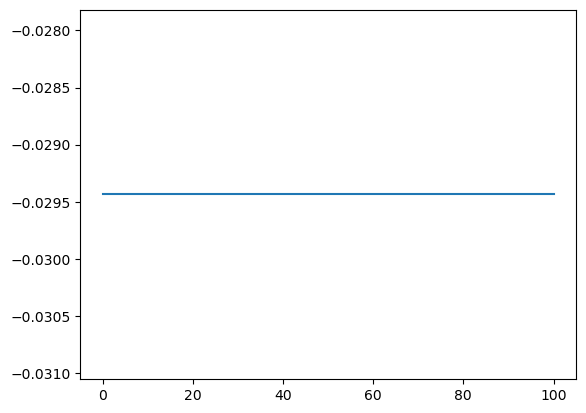

In [161]:
plt.plot(am_out['theta'][:,2])

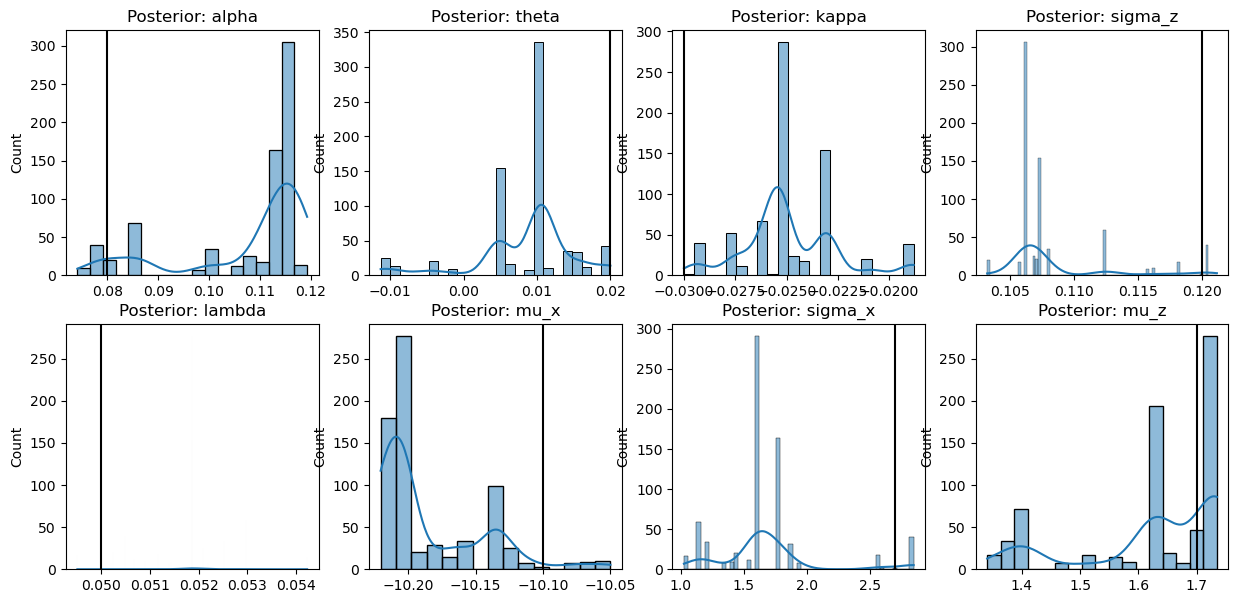

In [84]:
pg_theta = jax.vmap(jdmodel.get_theta, in_axes=(0,))(am_out['theta'])
plot_pg = pd.DataFrame({"iter": jnp.arange(n_iter),
                         "alpha": pg_theta[:,0],
                         "theta": pg_theta[:,1],
                         "kappa": pg_theta[:,2],
                         "sigma_z": pg_theta[:,3],
                         "lambda": pg_theta[:,4],
                         "mu_x": pg_theta[:,5],
                         "sigma_x": pg_theta[:,6],
                         "mu_z": pg_theta[:,7]})

fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(15, 7), sharex=False, sharey=False)
axes = axes.ravel()  # array to 1D
cols = plot_pg.columns[1:]  # create a list of dataframe columns to use

for col, ax in zip(cols, axes):
    data=plot_pg[[col]]
    sns.histplot(data=data, x=col, kde=True, ax=ax)
    ax.set(title=f'Posterior: {col}', xlabel=None)
    
for ax, theta in zip(axes, jdmodel.get_theta(my_theta)):
    ax.axvline(theta, color="black")

In [85]:
am_out['theta'][:,0]

DeviceArray([0.08      , 0.08      , 0.07993168, ...,        nan,
                    nan,        nan], dtype=float32)

In [66]:
random.multivariate_normal(key, my_theta, jnp.cov(pg_out["theta"].T))

DeviceArray([ 8.1722006e-02, -6.7136839e-02,  4.0527564e-03,
             -2.2846313e+00, -2.9283173e+00, -1.0083447e+01,
             -2.4807084e-01,  4.7491580e-01], dtype=float32)

In [91]:
jnp.cov(am_out['theta'][:500,:].T)

DeviceArray([[ 2.8336889e-04,  1.3086406e-04, -4.2373536e-05,
              -4.7545473e-04, -1.1563809e-03, -3.8064234e-03,
               2.2471007e-03,  7.5240451e-04],
             [ 1.3086406e-04,  1.2264759e-04, -3.3931865e-05,
              -2.2143959e-04, -8.6772896e-04, -2.7853488e-03,
               1.2731793e-03,  6.6761585e-04],
             [-4.2373536e-05, -3.3931865e-05,  1.3112037e-05,
               6.2203762e-05,  2.2332319e-04,  7.5504807e-04,
              -2.7865134e-04, -2.3060772e-04],
             [-4.7545473e-04, -2.2143959e-04,  6.2203762e-05,
               9.3525136e-04,  1.9118782e-03,  6.9514946e-03,
              -4.5406320e-03, -9.6952380e-04],
             [-1.1563809e-03, -8.6772896e-04,  2.2332319e-04,
               1.9118782e-03,  6.8912287e-03,  2.1034895e-02,
              -1.0961983e-02, -4.6786941e-03],
             [-3.8064234e-03, -2.7853488e-03,  7.5504807e-04,
               6.9514946e-03,  2.1034895e-02,  7.1834587e-02,
              -3.6362

In [89]:
am_out['theta'][:500,0]

DeviceArray([0.09071436, 0.09098689, 0.09098689, 0.09098689, 0.0889901 ,
             0.09788439, 0.09788439, 0.08576395, 0.08576395, 0.08576395,
             0.08576395, 0.08576395, 0.08576395, 0.08576395, 0.08576395,
             0.08576395, 0.08576395, 0.08576395, 0.08576395, 0.08576395,
             0.08576395, 0.10156386, 0.10156386, 0.10836516, 0.10836516,
             0.10836516, 0.10836516, 0.10836516, 0.10836516, 0.10836516,
             0.10836516, 0.10836516, 0.10836516, 0.10836516, 0.10836516,
             0.10836516, 0.10836516, 0.10836516, 0.10836516, 0.10836516,
             0.10836516, 0.10836516, 0.10836516, 0.10836516, 0.10836516,
             0.10836516, 0.10836516, 0.12654632, 0.12654632, 0.12654632,
             0.12654632, 0.12654632, 0.12654632, 0.12654632, 0.12654632,
             0.12654632, 0.12654632, 0.12654632, 0.12654632, 0.12654632,
             0.12654632, 0.12654632, 0.12654632, 0.12654632, 0.12654632,
             0.12654632, 0.12654632, 0.12654632, 0.

In [90]:
am_out['theta'][500:,0]

DeviceArray([0.1500499,       nan,       nan, ...,       nan,       nan,
                   nan], dtype=float32)

In [68]:
pg_theta_mean = jnp.mean(pg_theta,axis=(0,))

In [1]:
multinom_pf = pf.particle_filter(
    theta=pg_theta_mean, 
    model=jdmodel, 
    y_meas=y_meas, 
    n_particles=300, 
    resampler=resampler.resample_multinomial,
    key=my_key,
    history = True)

NameError: name 'pf' is not defined

In [ ]:
point_plot = pd.DataFrame(jnp.array([
    jnp.arange(y_meas.shape[0]) * my_n_res,
    y_meas
]).T, columns = ["Time", "Log Asset Price"])


def plot_particles (x_state, y_meas, vol_particles, price_particles, title=""):
    fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(7, 5), sharex = True)
    fig.suptitle(title)

    sns.lineplot(data= x_state[..., 1].reshape(my_n_res*my_n_obs, 1)[(my_n_res-1):].squeeze(),
                 ax = ax[0],
                 label = "Latent")
    sns.scatterplot(x = "Time", y = "Log Asset Price", 
                    data = point_plot,
                    color = "firebrick",
                    ax = ax[0],
                    label="Observed").set(xlabel="Time",title ="$X_t$");

    sns.lineplot(data= x_state[..., 0].reshape(my_n_res*my_n_obs,1)[(my_n_res-1):].squeeze(),
                 ax = ax[1],
                 label = "Latent Volatility").set(xlabel="Time",title = "$Z_t$", ylabel="Volatility");

    for t in range(my_n_obs-1):
        for s in range(my_n_res):
            my_x = (t*my_n_res) + s
            sns.scatterplot(x = my_x, 
                            y=price_particles[t, :, s], 
                            s = 2, 
                            color = "green", ax = ax[0]);
            sns.scatterplot(x = my_x, 
                            y=vol_particles[t, :, s], 
                            s = 2, 
                            color = "green", ax = ax[1]);


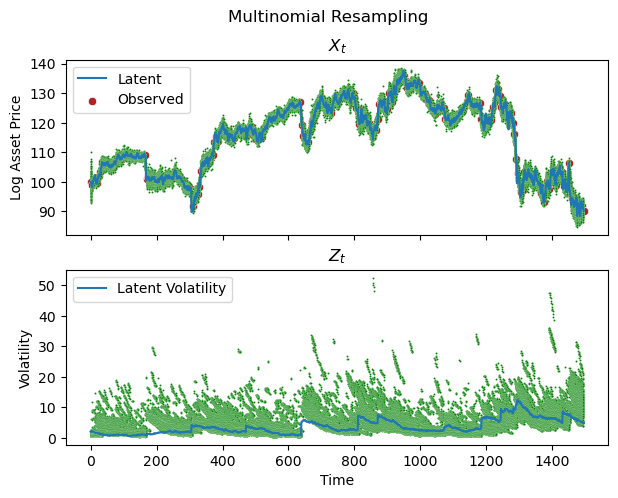

In [81]:
plot_particles(x_state, y_meas, 
               vol_particles=multinom_pf["x_particles"][1:, :, :, 0], 
               price_particles=multinom_pf["x_particles"][1:, :, :, 1],
               title = "Multinomial Resampling")